In [1]:
from collections import Counter
import gc
import os

from torch.utils.data import Dataset, DataLoader
from easydict import EasyDict as edict
from imutils.paths import list_images
from matplotlib import pyplot as plt
from torch.nn import functional as F
from sklearn.utils import resample
from torchvision import transforms
from sklearn.metrics import *
from tqdm.auto import tqdm
from torch import optim
from torch import nn
import pandas as pd
import numpy as np
import torch
import timm
import cv2

/opt/conda/envs/torch_1.x/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
gc.collect()
torch.cuda.empty_cache()

In [3]:
SEP       = os.path.sep
ROOT_PATH = SEP.join(os.getcwd().split(SEP)[:-4])
DATA_PATH = f'{ROOT_PATH}/Datasets/Pneumonia'

args              = {}
args['n_samples'] = 3
args['device']    = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
args['epochs']    = 15
args['seed']      = 999
args['bs']        = 32
args['lr']        = 5e-5
args              = edict(args)


In [4]:
labels = sorted(os.listdir(f'{DATA_PATH}/train'))
lb2idx = {lb  : idx for idx,  lb in enumerate(labels)}
idx2lb = {idx :  lb for  lb, idx in lb2idx.items()}

lb2idx, idx2lb

({'normal': 0, 'pneumonia': 1}, {0: 'normal', 1: 'pneumonia'})

In [5]:
class PneumoniaDataset(Dataset):
    
    def __init__(self, path, dtype = 'train'):
        
        self.image_paths = sorted(list_images(path))
        self.dtype       = dtype
        
        self.transform   = {}
        self.transform['train'] = transforms.Compose([
                                    transforms.ToPILImage(),
                                    transforms.Resize((500, 500)),
                                    transforms.CenterCrop(380),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor()
                                ])
        
        self.transform['test']  = transforms.Compose([
                                    transforms.ToPILImage(),
                                    transforms.Resize((500, 500)),
                                    transforms.CenterCrop(380),
                                    transforms.ToTensor()
                                ])
    
    
    def display_distribution(self, ax):
        
        labels = [path.split(SEP)[-2] for path in self.image_paths]
        lb_cnt = Counter(labels)
        
        ax.bar(lb_cnt.keys(), lb_cnt.values())
        for k, v in lb_cnt.items():
            
            ax.text(k, v, v,
                     ha = 'center',
                     va = 'bottom')
    
    def __len__(self):
        
        return len(self.image_paths)
    
    
    def __getitem__(self, idx):
        
        image_path = self.image_paths[idx]
        image      = cv2.imread(image_path)
        image      = self.transform[self.dtype](image)
        label      = image_path.split(SEP)[-2]
        
        return image, lb2idx[label]

In [6]:
train_dataset = PneumoniaDataset(f'{DATA_PATH}/train')
valid_dataset = PneumoniaDataset(f'{DATA_PATH}/val' , dtype = 'test')
test_dataset  = PneumoniaDataset(f'{DATA_PATH}/test', dtype = 'test')

train_loader  = DataLoader(train_dataset, batch_size = args.bs, shuffle =  True)
valid_loader  = DataLoader(valid_dataset, batch_size =       1, shuffle = False)
test_loader   = DataLoader(test_dataset , batch_size = args.bs, shuffle = False)

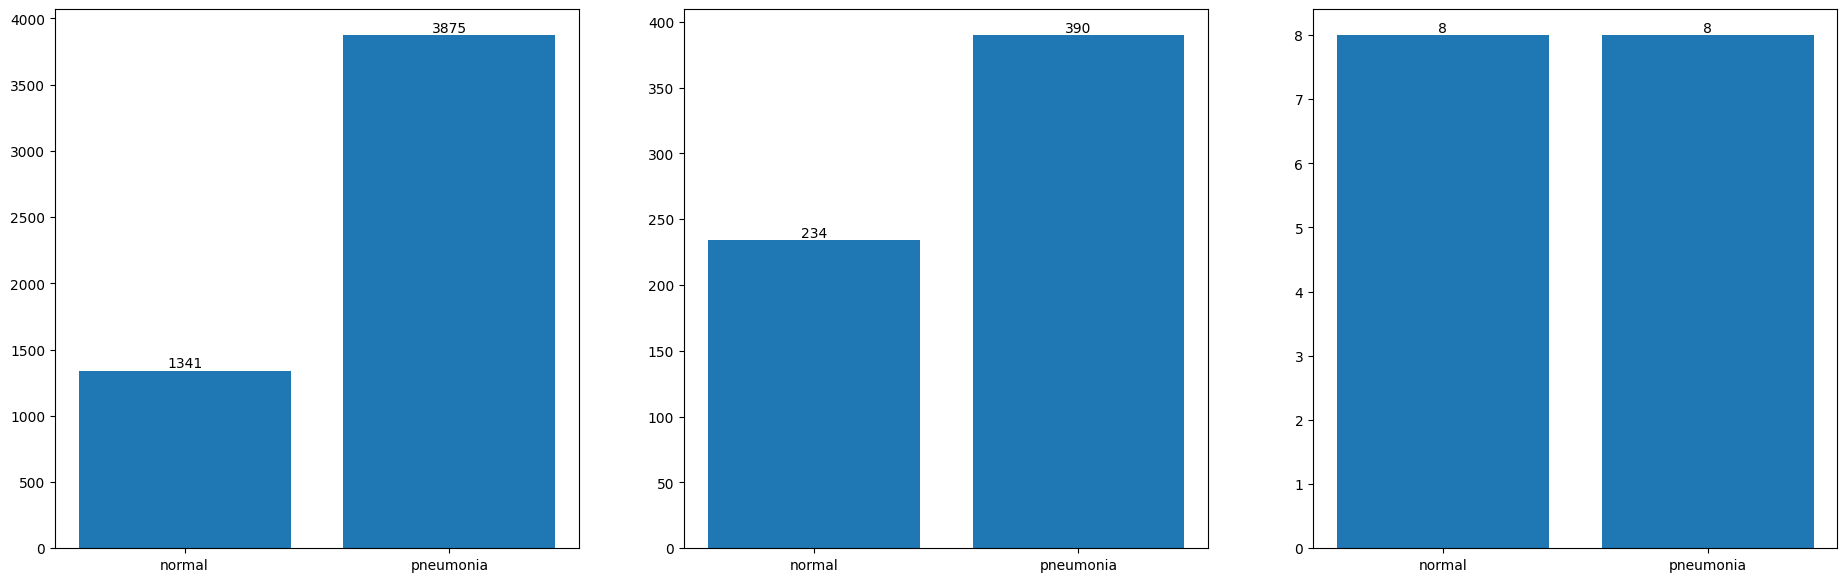

In [7]:
_, axes       = plt.subplots(1, 3, figsize = (23, 7))
train_dataset.display_distribution(axes[0])
valid_dataset.display_distribution(axes[2])
test_dataset.display_distribution(axes[1])

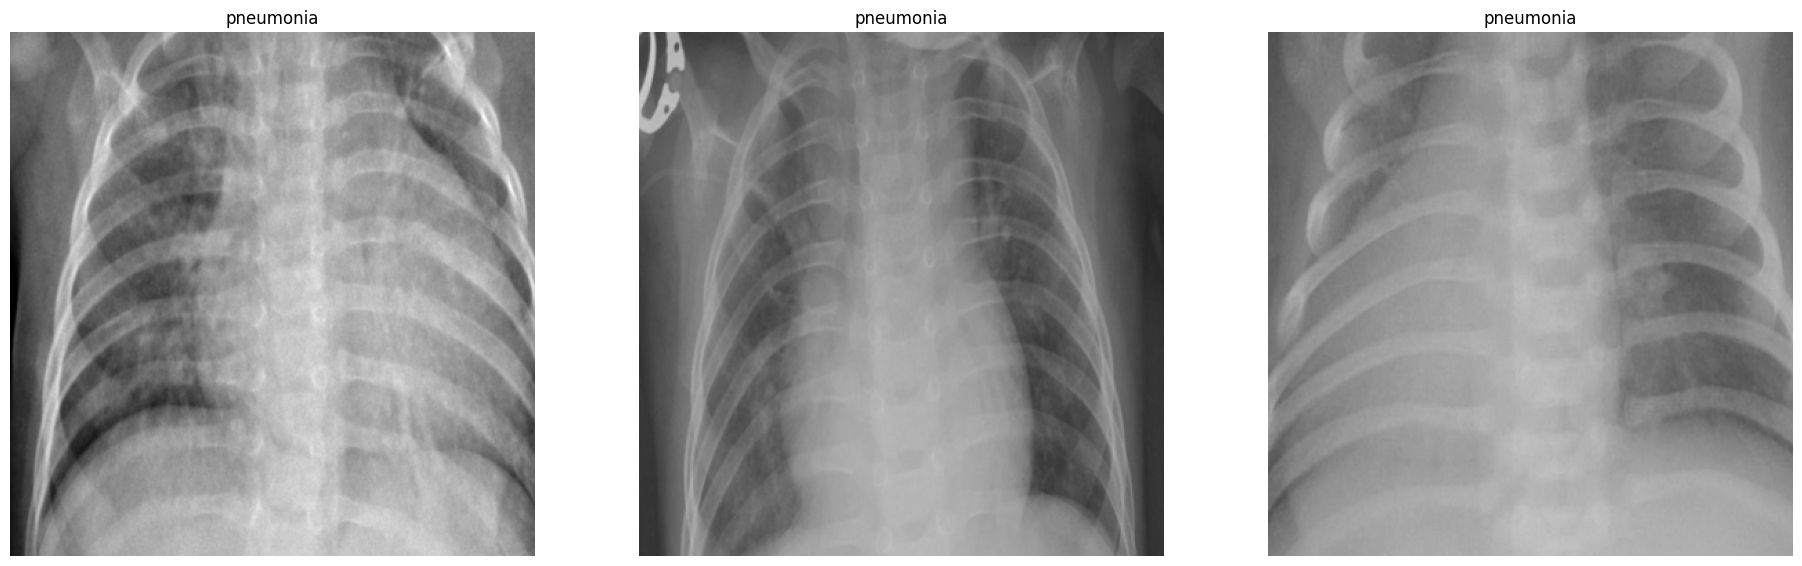

In [8]:
random_idx    = np.random.randint(0, len(train_dataset), args.n_samples)
_, axes       = plt.subplots(1, args.n_samples, figsize = (23, 7))

for idx, ax in zip(random_idx, axes):
    
    image     = train_dataset[idx][0]
    label     = train_dataset[idx][1]
    
    ax.imshow(image.numpy().transpose(1, 2, 0))
    ax.axis(False)
    ax.set_title(idx2lb[label])

In [9]:
timm.list_models('resnet*')

['resnet10t',
 'resnet14t',
 'resnet18',
 'resnet18d',
 'resnet26',
 'resnet26d',
 'resnet26t',
 'resnet32ts',
 'resnet33ts',
 'resnet34',
 'resnet34d',
 'resnet50',
 'resnet50_gn',
 'resnet50c',
 'resnet50d',
 'resnet50s',
 'resnet50t',
 'resnet51q',
 'resnet61q',
 'resnet101',
 'resnet101c',
 'resnet101d',
 'resnet101s',
 'resnet152',
 'resnet152c',
 'resnet152d',
 'resnet152s',
 'resnet200',
 'resnet200d',
 'resnetaa34d',
 'resnetaa50',
 'resnetaa50d',
 'resnetaa101d',
 'resnetblur18',
 'resnetblur50',
 'resnetblur50d',
 'resnetblur101d',
 'resnetrs50',
 'resnetrs101',
 'resnetrs152',
 'resnetrs200',
 'resnetrs270',
 'resnetrs350',
 'resnetrs420',
 'resnetv2_50',
 'resnetv2_50d',
 'resnetv2_50d_evos',
 'resnetv2_50d_frn',
 'resnetv2_50d_gn',
 'resnetv2_50t',
 'resnetv2_50x1_bit',
 'resnetv2_50x3_bit',
 'resnetv2_101',
 'resnetv2_101d',
 'resnetv2_101x1_bit',
 'resnetv2_101x3_bit',
 'resnetv2_152',
 'resnetv2_152d',
 'resnetv2_152x2_bit',
 'resnetv2_152x4_bit']

In [10]:
model = timm.create_model('efficientnet_b4', pretrained = True)
model.classifier = nn.Sequential(
                        nn.Linear(model.classifier.in_features, 512),
                        nn.ReLU(inplace = True),
                        nn.Dropout(0.4),
                        
                        nn.Linear(512, 128),
                        nn.ReLU(inplace = True),
                        nn.Dropout(0.4),
    
                        nn.Linear(128, 16),
                        nn.ReLU(inplace = True),
                        nn.Dropout(0.3),
    
                        nn.Linear(16, len(idx2lb))
                    )
model.to(args.device)
print('[Fine tunning is done!]')

/opt/conda/envs/torch_1.x/lib/python3.10/site-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


[Fine tunning is done!]


In [11]:
optimizer = optim.Adam(model.parameters(), lr = args.lr)
criterion = nn.CrossEntropyLoss()

In [12]:
def train(model, loader, optim):
    
    losses, acc = 0, 0
    
    model.train()
    for image, label in (pbar := tqdm(loader)):
        pbar.set_description('[TRAIN]')
        
        image = image.to(args.device)
        label = label.to(args.device)
        optim.zero_grad()
        
        output = model(image)
        loss   = criterion(output, label)
        pred   = output.max(1, keepdim = True)[1]
        
        loss.backward()
        optim.step()
        
        acc    += pred.eq(label.view_as(pred)).sum().item()
        losses += loss
        
    
    acc    /= len(loader.dataset)
    losses /= len(loader.dataset)
    
    return losses, acc
        

def evaluate(model, loader):
    
    losses, acc = 0, 0
    model.eval()
    
    with torch.no_grad():
        for image, label in (pbar := tqdm(loader)):

            pbar.set_description('[EVAL]')
            image   = image.to(args.device)
            label   = label.to(args.device)

            output  = model(image)
            loss    = criterion(output, label)
            pred    = output.max(1, keepdim = True)[1]
            
            acc    += pred.eq(label.view_as(pred)).sum().item()
            losses += loss.item()
            
    acc    /= len(loader.dataset)
    losses /= len(loader.dataset)
    
    return losses, acc

In [13]:
for epoch in range(1, args.epochs + 1):
    
    print(f'[{epoch}/{args.epochs}]')
    train_loss, train_acc = train(model, train_loader, optimizer)
    test_loss , test_acc  = evaluate(model, test_loader)
    
    print(f'[TRAIN] acc : {train_acc * 100:.3f}%, loss : {train_loss:.3f}')
    print(f'[TEST]  acc : {test_acc * 100:.3f}%, loss : {test_loss:.3f}\n')

[1/15]


[EVAL]: 100%|██████████| 20/20 [00:15<00:00,  1.28it/s]


[TRAIN] acc : 81.461%, loss : 0.012
[TEST]  acc : 82.532%, loss : 0.018

[2/15]


[EVAL]: 100%|██████████| 20/20 [00:17<00:00,  1.13it/s]


[TRAIN] acc : 95.916%, loss : 0.004
[TEST]  acc : 80.449%, loss : 0.027

[3/15]


[EVAL]: 100%|██████████| 20/20 [00:13<00:00,  1.46it/s]


[TRAIN] acc : 97.354%, loss : 0.003
[TEST]  acc : 78.686%, loss : 0.033

[4/15]


[EVAL]: 100%|██████████| 20/20 [00:15<00:00,  1.32it/s]


[TRAIN] acc : 98.600%, loss : 0.002
[TEST]  acc : 80.929%, loss : 0.029

[5/15]


[EVAL]: 100%|██████████| 20/20 [00:16<00:00,  1.18it/s]


[TRAIN] acc : 98.562%, loss : 0.001
[TEST]  acc : 83.974%, loss : 0.032

[6/15]


[EVAL]: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s]


[TRAIN] acc : 99.022%, loss : 0.001
[TEST]  acc : 81.891%, loss : 0.029

[7/15]


[EVAL]: 100%|██████████| 20/20 [00:15<00:00,  1.26it/s]


[TRAIN] acc : 99.348%, loss : 0.001
[TEST]  acc : 84.135%, loss : 0.071

[8/15]


[EVAL]: 100%|██████████| 20/20 [00:17<00:00,  1.16it/s]


[TRAIN] acc : 99.540%, loss : 0.000
[TEST]  acc : 85.096%, loss : 0.027

[9/15]


[EVAL]: 100%|██████████| 20/20 [00:16<00:00,  1.18it/s]


[TRAIN] acc : 99.578%, loss : 0.000
[TEST]  acc : 80.449%, loss : 0.051

[10/15]


[EVAL]: 100%|██████████| 20/20 [00:14<00:00,  1.34it/s]


[TRAIN] acc : 99.789%, loss : 0.000
[TEST]  acc : 82.532%, loss : 0.043

[11/15]


[EVAL]: 100%|██████████| 20/20 [00:15<00:00,  1.29it/s]


[TRAIN] acc : 99.597%, loss : 0.000
[TEST]  acc : 82.051%, loss : 0.040

[12/15]


[EVAL]: 100%|██████████| 20/20 [00:14<00:00,  1.35it/s]


[TRAIN] acc : 99.808%, loss : 0.000
[TEST]  acc : 83.013%, loss : 0.070

[13/15]


[EVAL]: 100%|██████████| 20/20 [00:16<00:00,  1.18it/s]


[TRAIN] acc : 99.808%, loss : 0.000
[TEST]  acc : 80.449%, loss : 0.049

[14/15]


[EVAL]: 100%|██████████| 20/20 [00:17<00:00,  1.16it/s]


[TRAIN] acc : 99.789%, loss : 0.000
[TEST]  acc : 82.532%, loss : 0.044

[15/15]


[EVAL]: 100%|██████████| 20/20 [00:17<00:00,  1.17it/s]

[TRAIN] acc : 99.808%, loss : 0.000
[TEST]  acc : 80.128%, loss : 0.053



In [14]:
preds, gt = [], []
to_numpy = lambda x: x.detach().cpu().numpy()

model.eval()
with torch.no_grad():
    
    for image, label in valid_loader:
        
        image = image.to(args.device)
        label = label.to(args.device)
        
        output = model(image)
        pred   = to_numpy(output.max(1, keepdim = True)[1])[0]
        
        preds.extend(pred)
        gt.extend(to_numpy(label))
        
print(classification_report(gt, preds))

              precision    recall  f1-score   support

           0       1.00      0.38      0.55         8
           1       0.62      1.00      0.76         8

    accuracy                           0.69        16
   macro avg       0.81      0.69      0.65        16
weighted avg       0.81      0.69      0.65        16

